### 前向扩散+后向去噪的整体代码（两比特,测辅助比特）

代码思路：

加噪参数预定义；构建加噪，去噪电路；定义损失函数，优化参数

去噪优化好后，构建每一步去噪测试函数，观察效果

构建从混态开始的去噪，观察效果

代码细节：

每步的去噪训练由两部分组成：构建电路；定义损失函数，优化参数

去噪演示由一块代码完整构成

In [20]:
from qiskit import Aer
import numpy as np
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
from qiskit.circuit import ParameterVector

from qutip import Bloch, about, basis, destroy, sesolve, sigmax, sigmay, sigmaz, expect, Qobj
import matplotlib as mpl
import numpy as np
from matplotlib import cm

%matplotlib inline

0.6164172468281909


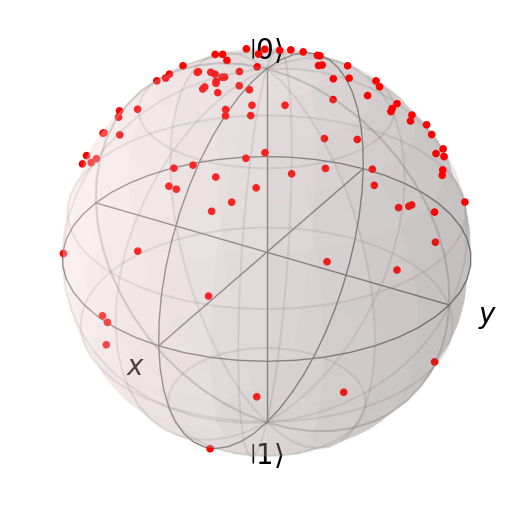

In [21]:
'''此处为加噪散点扩散演示'''

veclst=[]
totltime=5 #时间步
newrepeat = 100 # sample 点数目
cir = [QuantumCircuit(2) for i in range(newrepeat)]
qbt = 2


for each in range(newrepeat):
    np.random.seed(each)
    for t in range(totltime): 
        thetalstdf = (np.random.rand(4*qbt)-0.5)*np.pi/2
        for i in range(qbt):
            cir[each].rz(thetalstdf[0],i)
            cir[each].ry(thetalstdf[1],i)
            cir[each].rz(thetalstdf[2],i)
        cir[each].rzz(thetalstdf[3],0,1)
        # cir[each].barrier([0])

    veclst.append(Statevector(cir[each])) #添加每个点的vector
# cir[1].draw('mpl')

#调用qutip画球面上的散点
b = Bloch()

newv=[]
for i in range(len(veclst)):
    under = np.sqrt(np.abs(veclst[i][0]**2) + np.abs(veclst[i][1]**2))
    newv.append(Qobj([[veclst[i][0]]/under,[veclst[i][1]]/under]))
# add data points from expectation values ##
x=expect(sigmax(), newv)
y=expect(sigmay(), newv)
z=expect(sigmaz(), newv)
print(sum(z)/len(z))
b.add_points([x,y,z], "m")

# customize sphere properties ##
b.point_color = ['r']
b.point_marker = ["o"]
b.point_size = [20]

b.zlpos = [1.1, -1.2]

b.show()

不同sample加噪不同，先准备好加噪电路的相关参数

In [22]:
swapn = 6
theta_scale = np.pi/2 #控制旋转幅度
qbt = 2
repeat = 100 # 互相独立的点,sample数量
mean = 50 # 在sample里随机抽取mean组做swap
veclst=[]

ttime = 3 #总时间

thetalst = [[] for t in range(ttime)] # thetalst1[time][sample num]
for i in range(repeat):
    np.random.seed(i) #每个点diffusion不同
    for t in range(ttime):
        thetalst[t].append((np.random.rand(3*qbt)-0.5)*theta_scale)

zzthetalst = [[] for t in range(ttime)] # thetalst1[time][sample num]
for i in range(repeat):
    np.random.seed(i+5) #每个点diffusion不同
    for t in range(ttime):
        zzthetalst[t].append((np.random.rand()-0.5)*theta_scale)

print(len(thetalst[1][14]))


6


为了实现在某一步去噪,构建到该步的diffusion线路,这里选择为t=2步 (注意本步必须在第一步去噪结束并完成paramenter_binding后执行,下同)

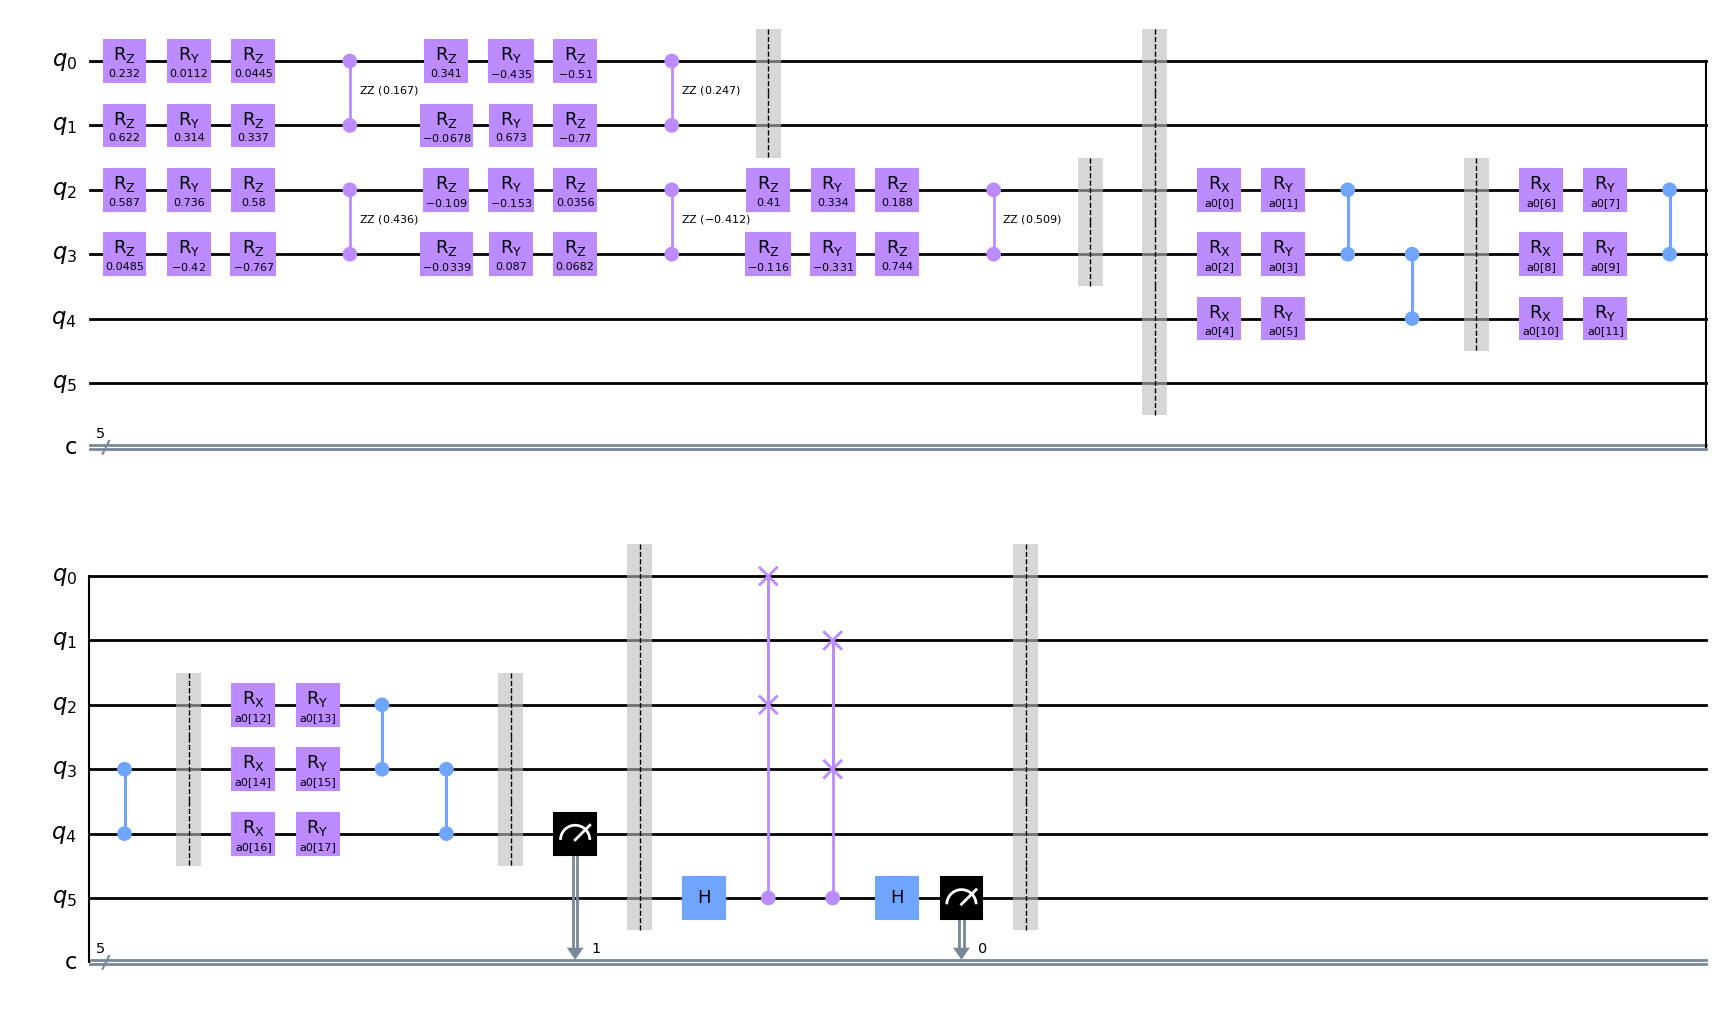

In [23]:
time=2
circlst = [QuantumCircuit(swapn,5) for num in range(mean)] #构建电路/初始化

for each in range(mean):
    randcp = [np.random.randint(0,repeat) for i in range(2)] #随机选取加噪去噪对
    
    for t in range(time): # reference diffusion 加噪
        for i in range(qbt):
            circlst[each].rz(thetalst[t][randcp[0]][0+i*3],i)
            circlst[each].ry(thetalst[t][randcp[0]][1+i*3],i)
            circlst[each].rz(thetalst[t][randcp[0]][2+i*3],i)
        circlst[each].rzz(zzthetalst[t][randcp[0]],0,1)
    circlst[each].barrier(np.arange(2))

    for t in range(ttime): # total diffusion 整体加噪
        for i in range(qbt):
            circlst[each].rz(thetalst[t][randcp[1]][0+i*3],2+i)
            circlst[each].ry(thetalst[t][randcp[1]][1+i*3],2+i)
            circlst[each].rz(thetalst[t][randcp[1]][2+i*3],2+i)
        circlst[each].rzz(zzthetalst[t][randcp[1]],2,3)
    circlst[each].barrier(np.arange(2,4))
        
    circlst[each].barrier(np.arange(swapn))
    # veclst.append(Statevector(circlst[each])) #添加每个点的vector

#denoising process 第一步的去噪
layers = 3
totalq = 3
thetalsta = [ParameterVector(f'a{each}',18) for each in range(mean)]

for each in range(mean):
    for n in range(layers):
        for i in range(totalq):
            circlst[each].rx(thetalsta[each][0+2*i+n*2*totalq],i+2)
            circlst[each].ry(thetalsta[each][1+2*i+n*2*totalq],i+2)
        for i in range(totalq):
            if i<totalq-1:
                circlst[each].cz(i+2,i+3)
        circlst[each].barrier(range(2,2+totalq))

    #swap test
    circlst[each].measure(4,1) #测量辅助比特
    circlst[each].barrier(range(swapn))
    circlst[each].h(5)
    circlst[each].cswap(5,0,2)
    circlst[each].cswap(5,1,3)
    circlst[each].h(5)
    circlst[each].measure(5,0)
    circlst[each].barrier(range(swapn))
circlst[0].draw('mpl')

398.9
[ 0.82417642  1.0256258   0.02760217  0.09682544  2.24471246 -1.76036168
  1.81315377 -2.40923607 -0.03694741  1.73371575 -1.46453083 -0.60561959
 -0.14434629  0.09033815 -0.25408638 -1.75124232 -0.656559    0.22394084]
167.88


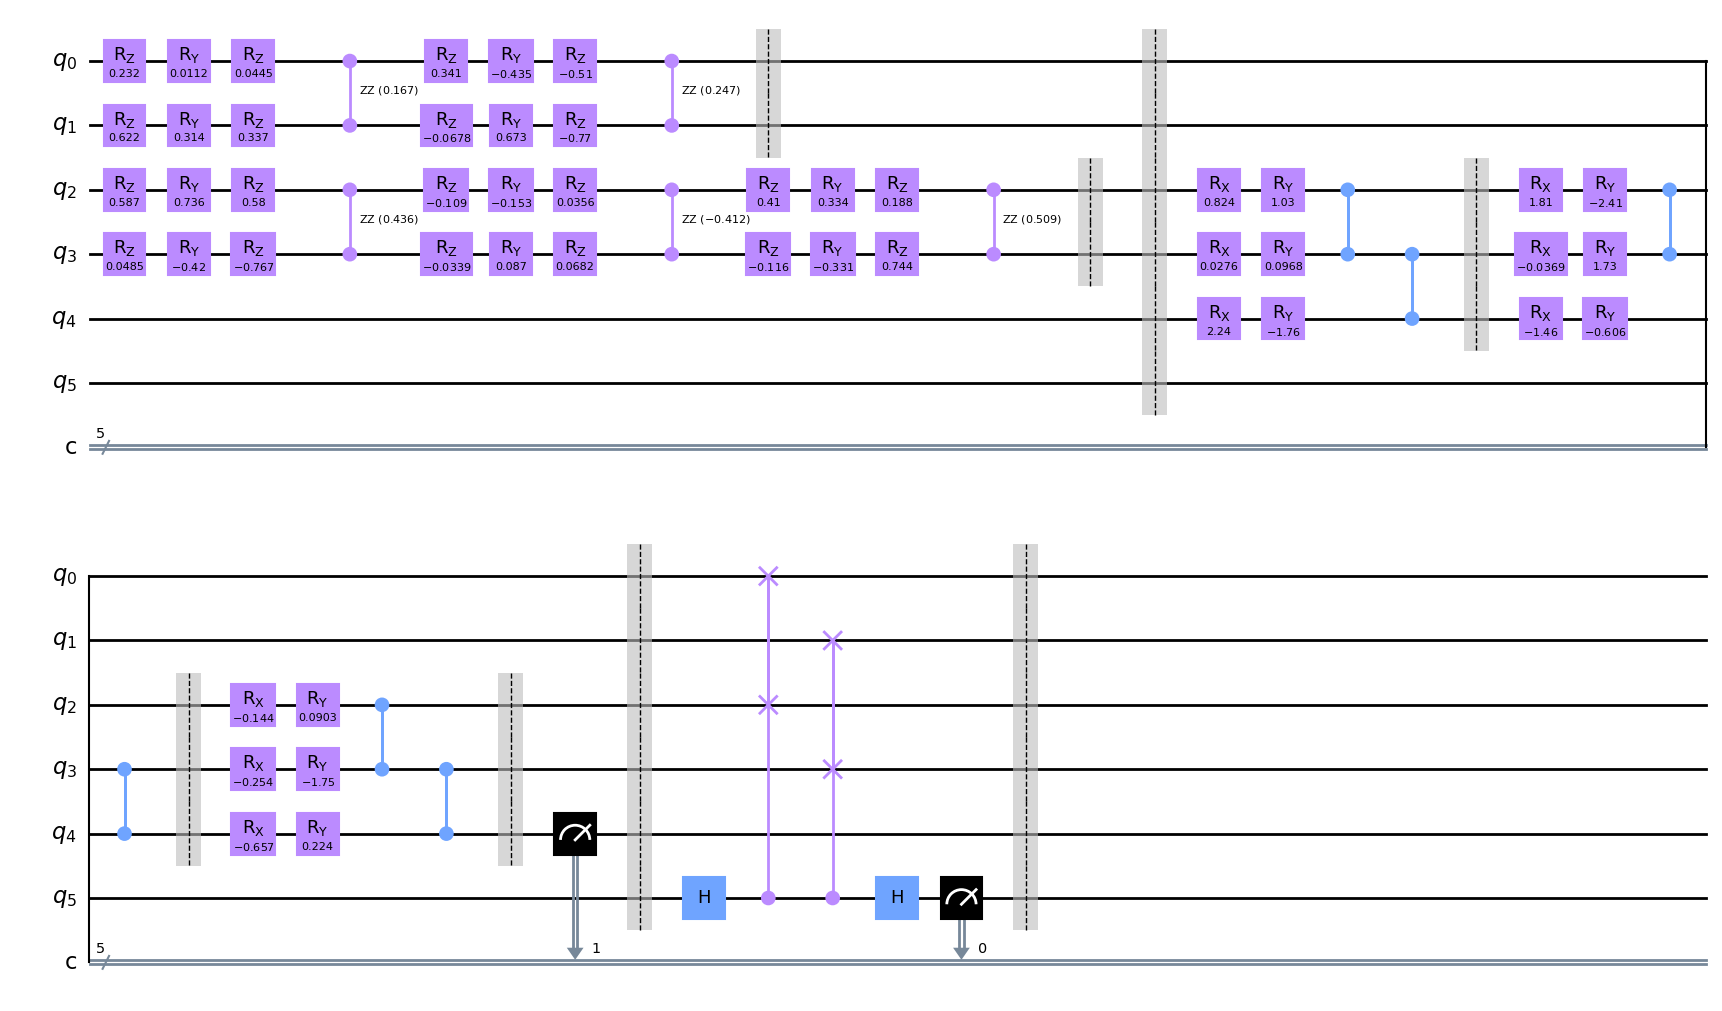

In [24]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

def cost_function_vqe(theta_range): #损失函数,这里xxxx0代表前向和后向重合,该值越大,去噪效果越好,因此需要最小xxxx1的频率
    count = 0
    for each in range(mean):
        circuits = circlst[each].bind_parameters({thetalsta[each]: theta_range})
        job_sim = backend_sim.run(transpile(circuits, backend_sim), shots=1024)

        result_sim = job_sim.result()
        counts = result_sim.get_counts(circuits)
        
        for i in counts.keys():
            if i[-1]=='1':
                count += counts[i]
    return count/mean

print(cost_function_vqe(np.random.randn(18))) 

### Optimizaion of denoising circuit parameters 优化参数
from qiskit.algorithms.optimizers import SPSA

initial_theta = np.random.randn(18)
optimizer = SPSA()
optimizer_result = optimizer.minimize(fun=cost_function_vqe, x0=initial_theta)
optimal_parameters_1 = optimizer_result.x
print(optimal_parameters_1)

print(cost_function_vqe(optimal_parameters_1))

for each in range(mean):
    circlst[each] = circlst[each].bind_parameters({thetalsta[each]: optimal_parameters_1})
circlst[0].draw('mpl')

In [25]:
#最优化参数写入文件
# with open('opp1.txt','w') as f:
#     f.write(str(optimal_parameters_1))

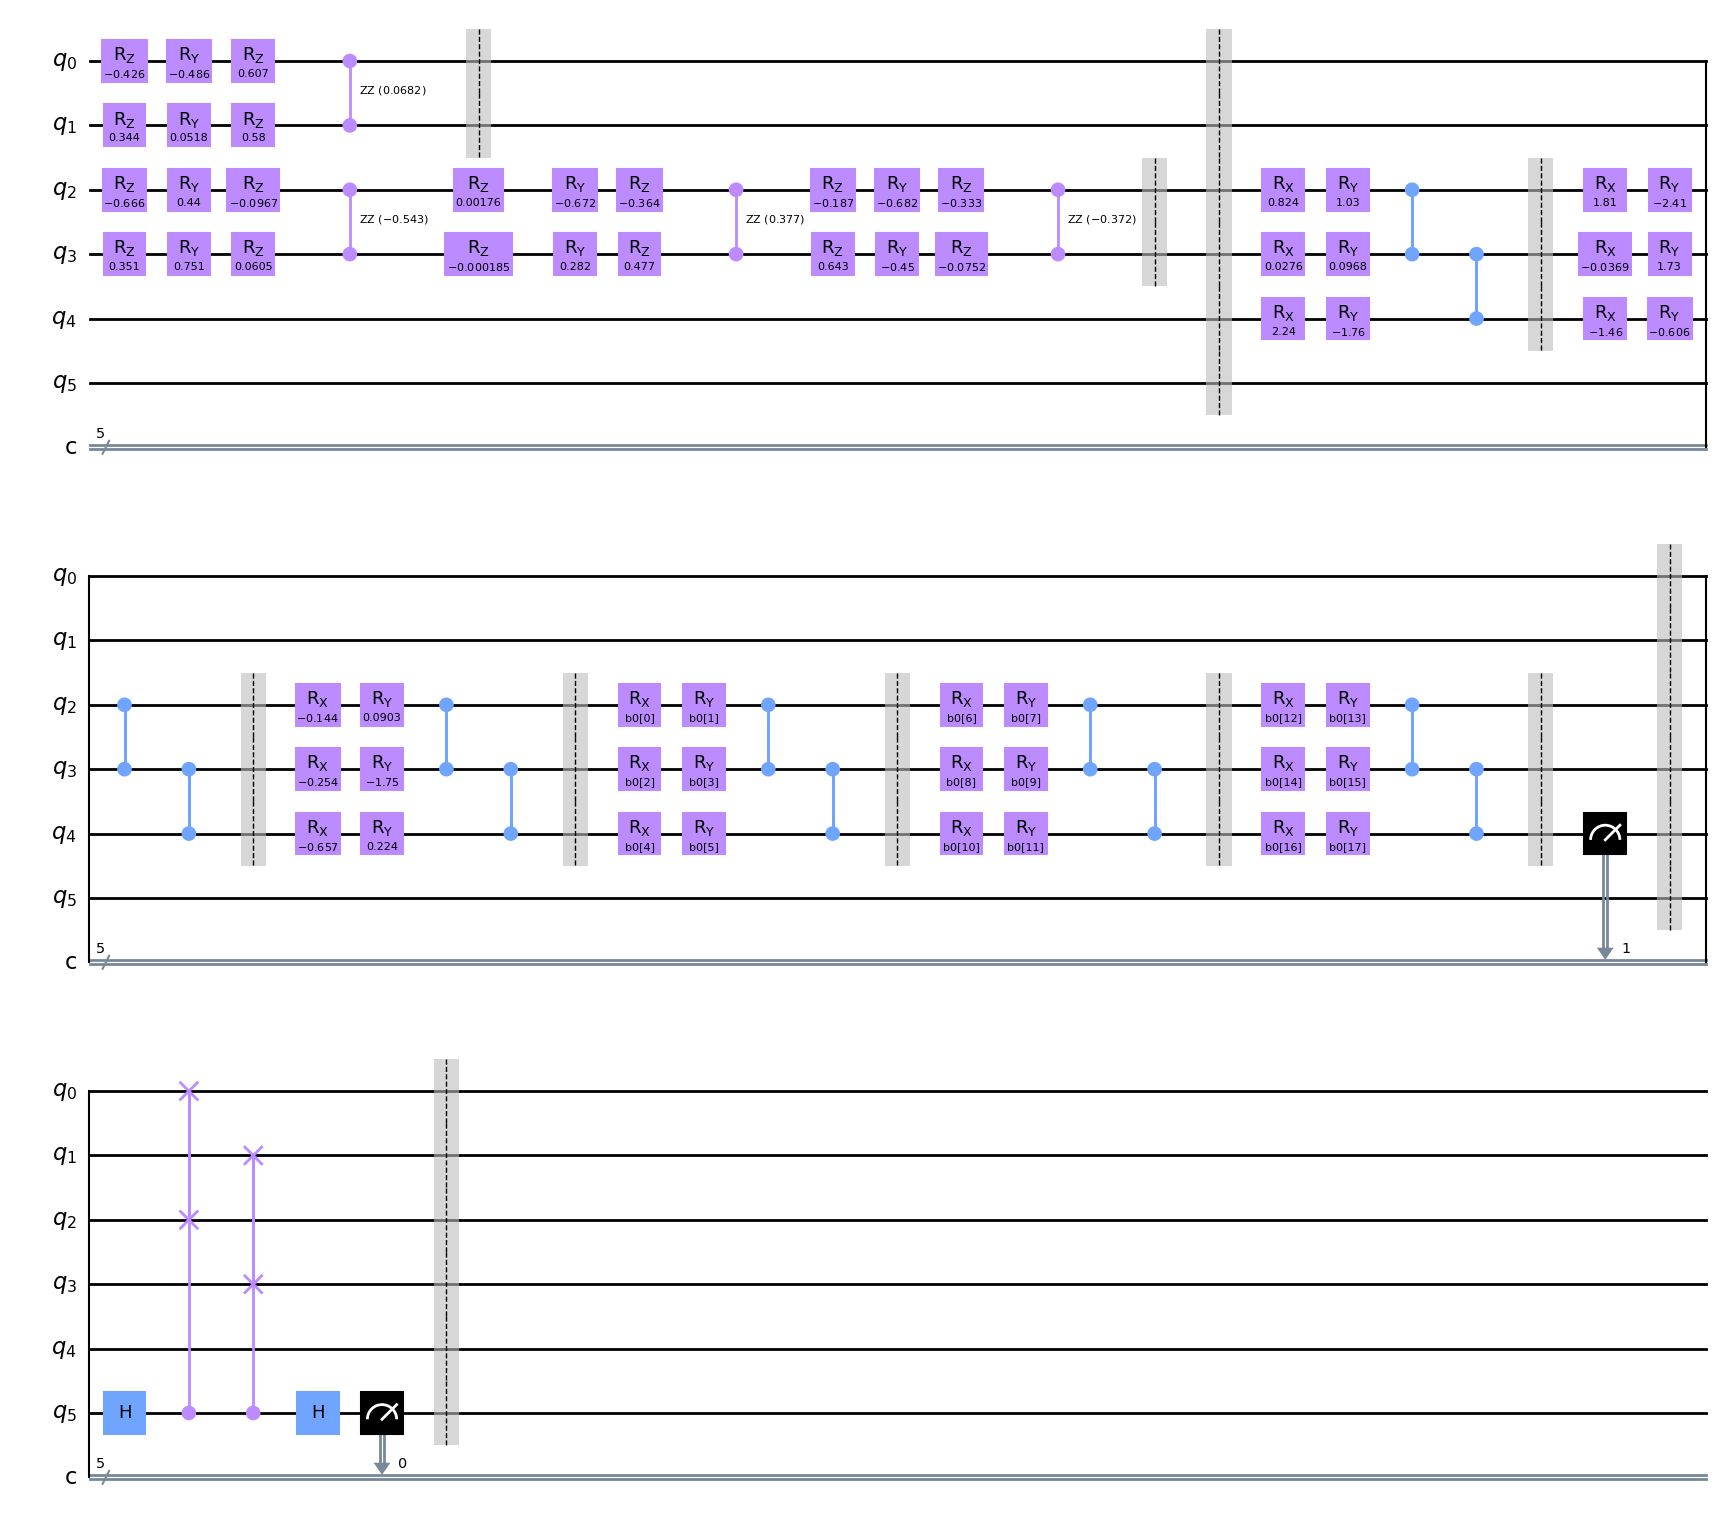

In [26]:
# 为了实现在某一步去噪,构建到该步的diffusion线路,这里选择为t=1步
time=1
circlst2 = [QuantumCircuit(swapn,5) for num in range(mean)] #每个点独立的电路

for each in range(mean):

    randcp = [np.random.randint(0,repeat) for i in range(2)] #随机选取加噪去噪对
    
    for t in range(time): # reference diffusion 加噪
        for i in range(qbt):
            circlst2[each].rz(thetalst[t][randcp[0]][0+i*3],i)
            circlst2[each].ry(thetalst[t][randcp[0]][1+i*3],i)
            circlst2[each].rz(thetalst[t][randcp[0]][2+i*3],i)
        circlst2[each].rzz(zzthetalst[t][randcp[0]],0,1)
    circlst2[each].barrier(np.arange(2))

    for t in range(ttime): # total diffusion 整体加噪
        for i in range(qbt):
            circlst2[each].rz(thetalst[t][randcp[1]][0+i*3],2+i)
            circlst2[each].ry(thetalst[t][randcp[1]][1+i*3],2+i)
            circlst2[each].rz(thetalst[t][randcp[1]][2+i*3],2+i)
        circlst2[each].rzz(zzthetalst[t][randcp[1]],2,3)
    circlst2[each].barrier(np.arange(2,4))

    circlst2[each].barrier(np.arange(swapn))
    # veclst.append(Statevector(circlst2[each])) #添加每个点的vector


#denoising process 加入第一步去噪的结果
layers = 3
thetalsta = [ParameterVector(f'a{each}',18) for each in range(mean)]

for each in range(mean):
    for n in range(layers):
        for i in range(totalq):
            circlst2[each].rx(thetalsta[each][0+2*i+n*2*totalq],i+2)
            circlst2[each].ry(thetalsta[each][1+2*i+n*2*totalq],i+2)
        for i in range(totalq):
            if i<totalq-1:
                circlst2[each].cz(i+2,i+3)
        circlst2[each].barrier(range(2,2+totalq))

    circlst2[each] = circlst2[each].bind_parameters({thetalsta[each]: optimal_parameters_1})
# with open('opp1.txt', 'r') as f:
#     op1 = np.array(f.read())
    
circlst2[0].draw('mpl')

#denoising process 第二步去噪
layers = 3
thetalstb = [ParameterVector(f'b{each}',18) for each in range(mean)]

for each in range(mean):
    for n in range(layers):
        for i in range(totalq):
            circlst2[each].rx(thetalstb[each][0+2*i+n*2*totalq],i+2)
            circlst2[each].ry(thetalstb[each][1+2*i+n*2*totalq],i+2)
        for i in range(totalq):
            if i<totalq-1:
                circlst2[each].cz(i+2,i+3)
        circlst2[each].barrier(range(2,2+totalq))


    #swap test
    circlst2[each].measure(4,1) #测量辅助比特
    circlst2[each].barrier(range(swapn))
    circlst2[each].h(5)
    circlst2[each].cswap(5,0,2)
    circlst2[each].cswap(5,1,3)
    circlst2[each].h(5)
    circlst2[each].measure(5,0)
    circlst2[each].barrier(range(swapn))
    circlst2[each].draw('mpl')
circlst2[0].draw('mpl')

[-3.48004104 -0.74619784  2.50773901 -0.28831093  2.25077055 -2.04240511
 -3.08243763 -2.70177392 -0.42185779  2.98329572  2.6772669  -1.60383768
 -2.6130171  -6.69946955 -2.72049958  2.48022176 -0.95949739 -2.73331815]
148.46


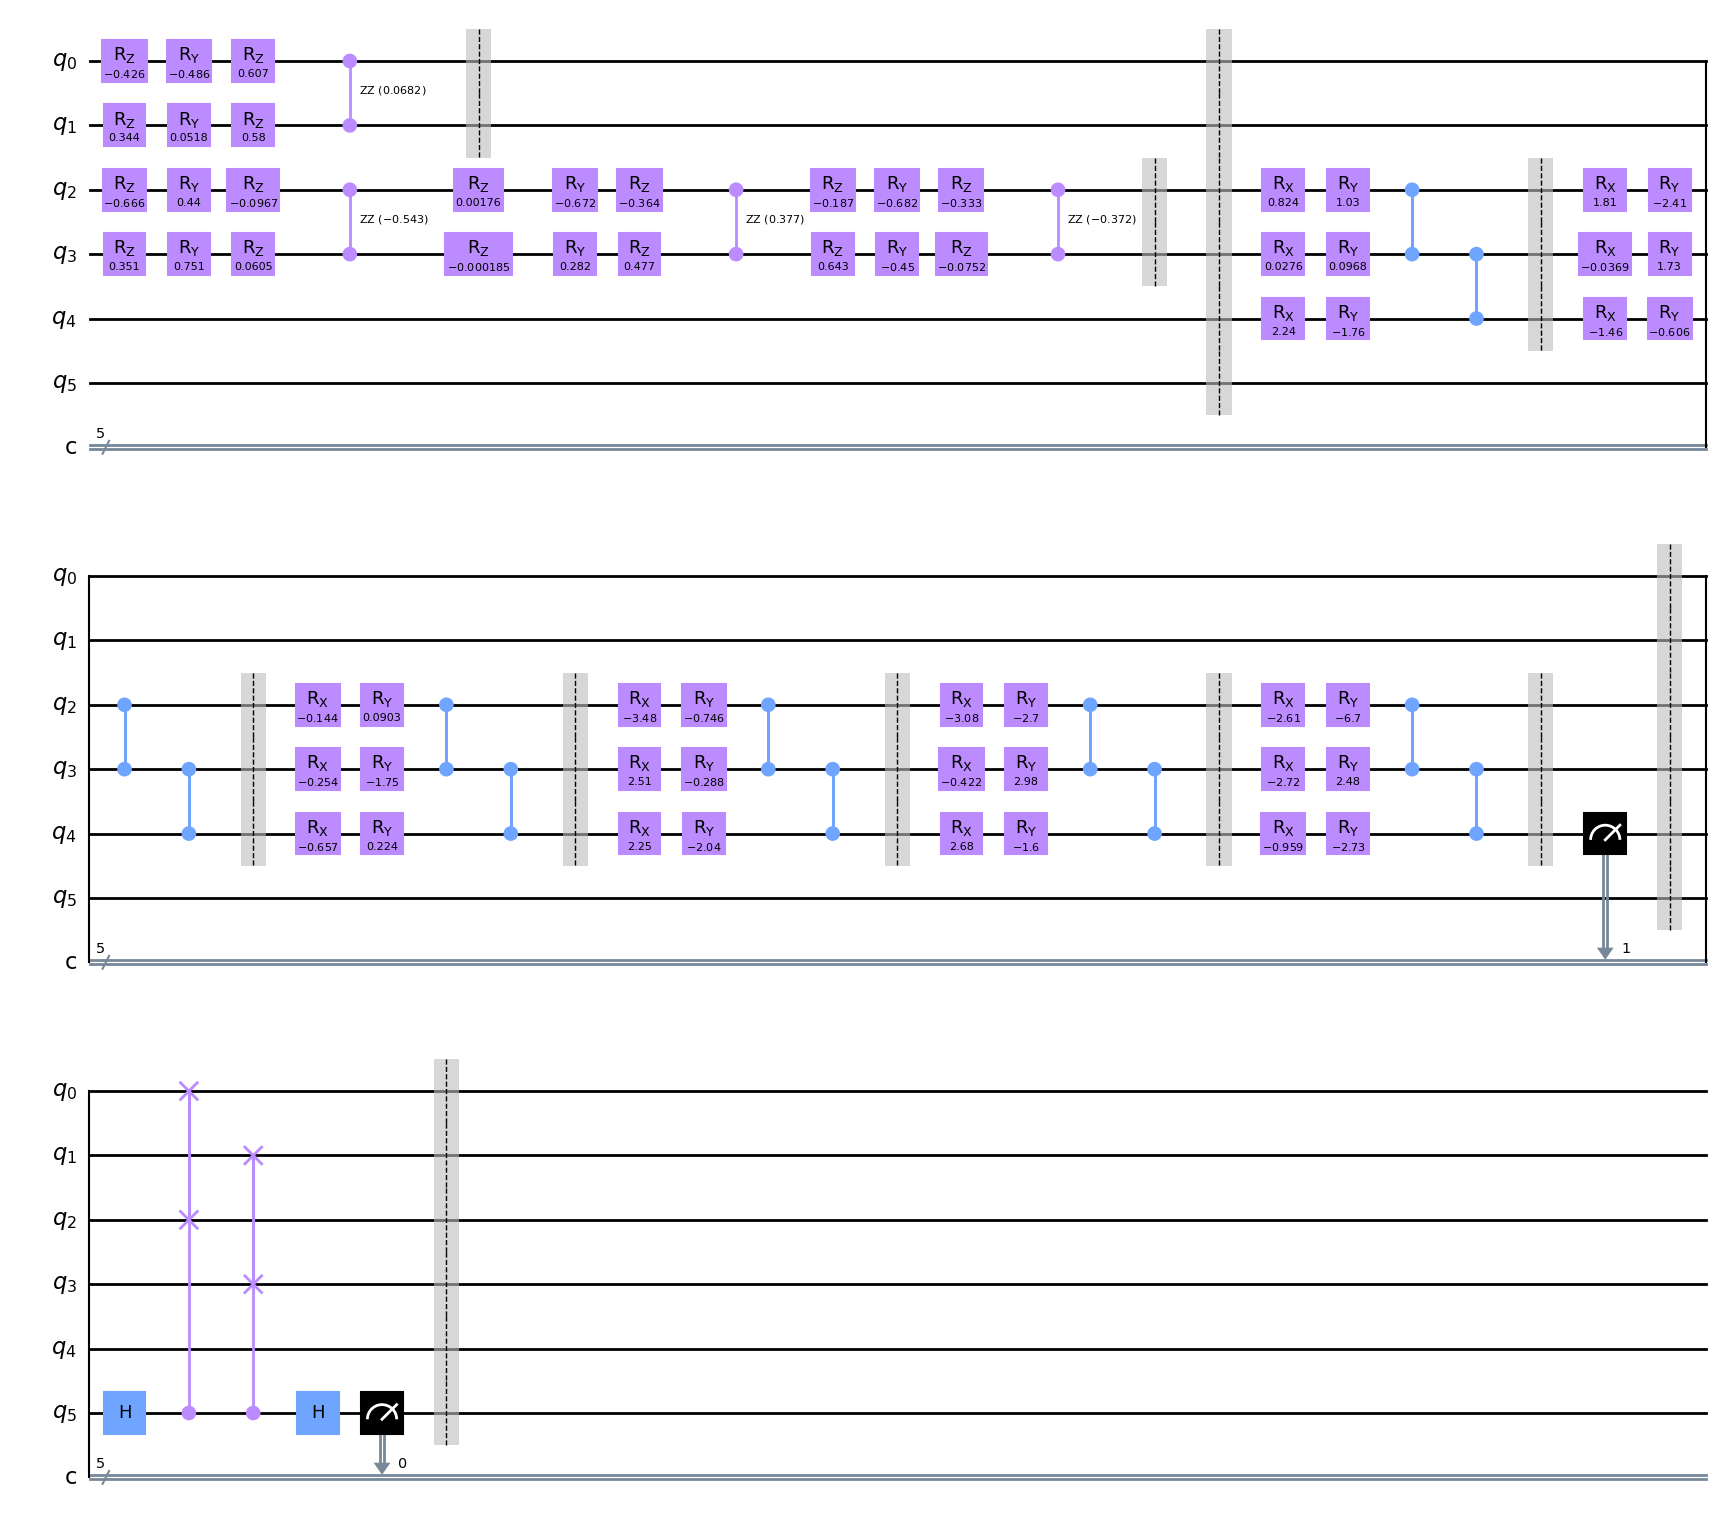

In [27]:
def cost_function_vqe_2(theta_range): #损失函数,这里xxxx0代表前向和后向重合,该值越大,去噪效果越好,因此需要最小xxxx1的频率
    count = 0
    for each in range(mean):
        circuits = circlst2[each].bind_parameters({thetalstb[each]: theta_range})
        job_sim = backend_sim.run(transpile(circuits, backend_sim), shots=1024)

        result_sim = job_sim.result()
        counts = result_sim.get_counts(circuits)

        for i in counts.keys():
            if i[-1]=='1':
                count += counts[i]
    return count/mean

### Optimizaion of denoising circuit parameters 优化参数
initial_theta = np.random.randn(18)
optimizer = SPSA()

optimizer_result = optimizer.minimize(fun=cost_function_vqe_2, x0=initial_theta)
optimal_parameters_2 = optimizer_result.x

print(optimal_parameters_2)
print(cost_function_vqe_2(optimal_parameters_2))

for each in range(mean):
    circlst2[each] = circlst2[each].bind_parameters({thetalstb[each]: optimal_parameters_2})
circlst2[0].draw('mpl')

In [28]:
# with open('opp2.txt','w') as f:
#     f.write(str(optimal_parameters_2))

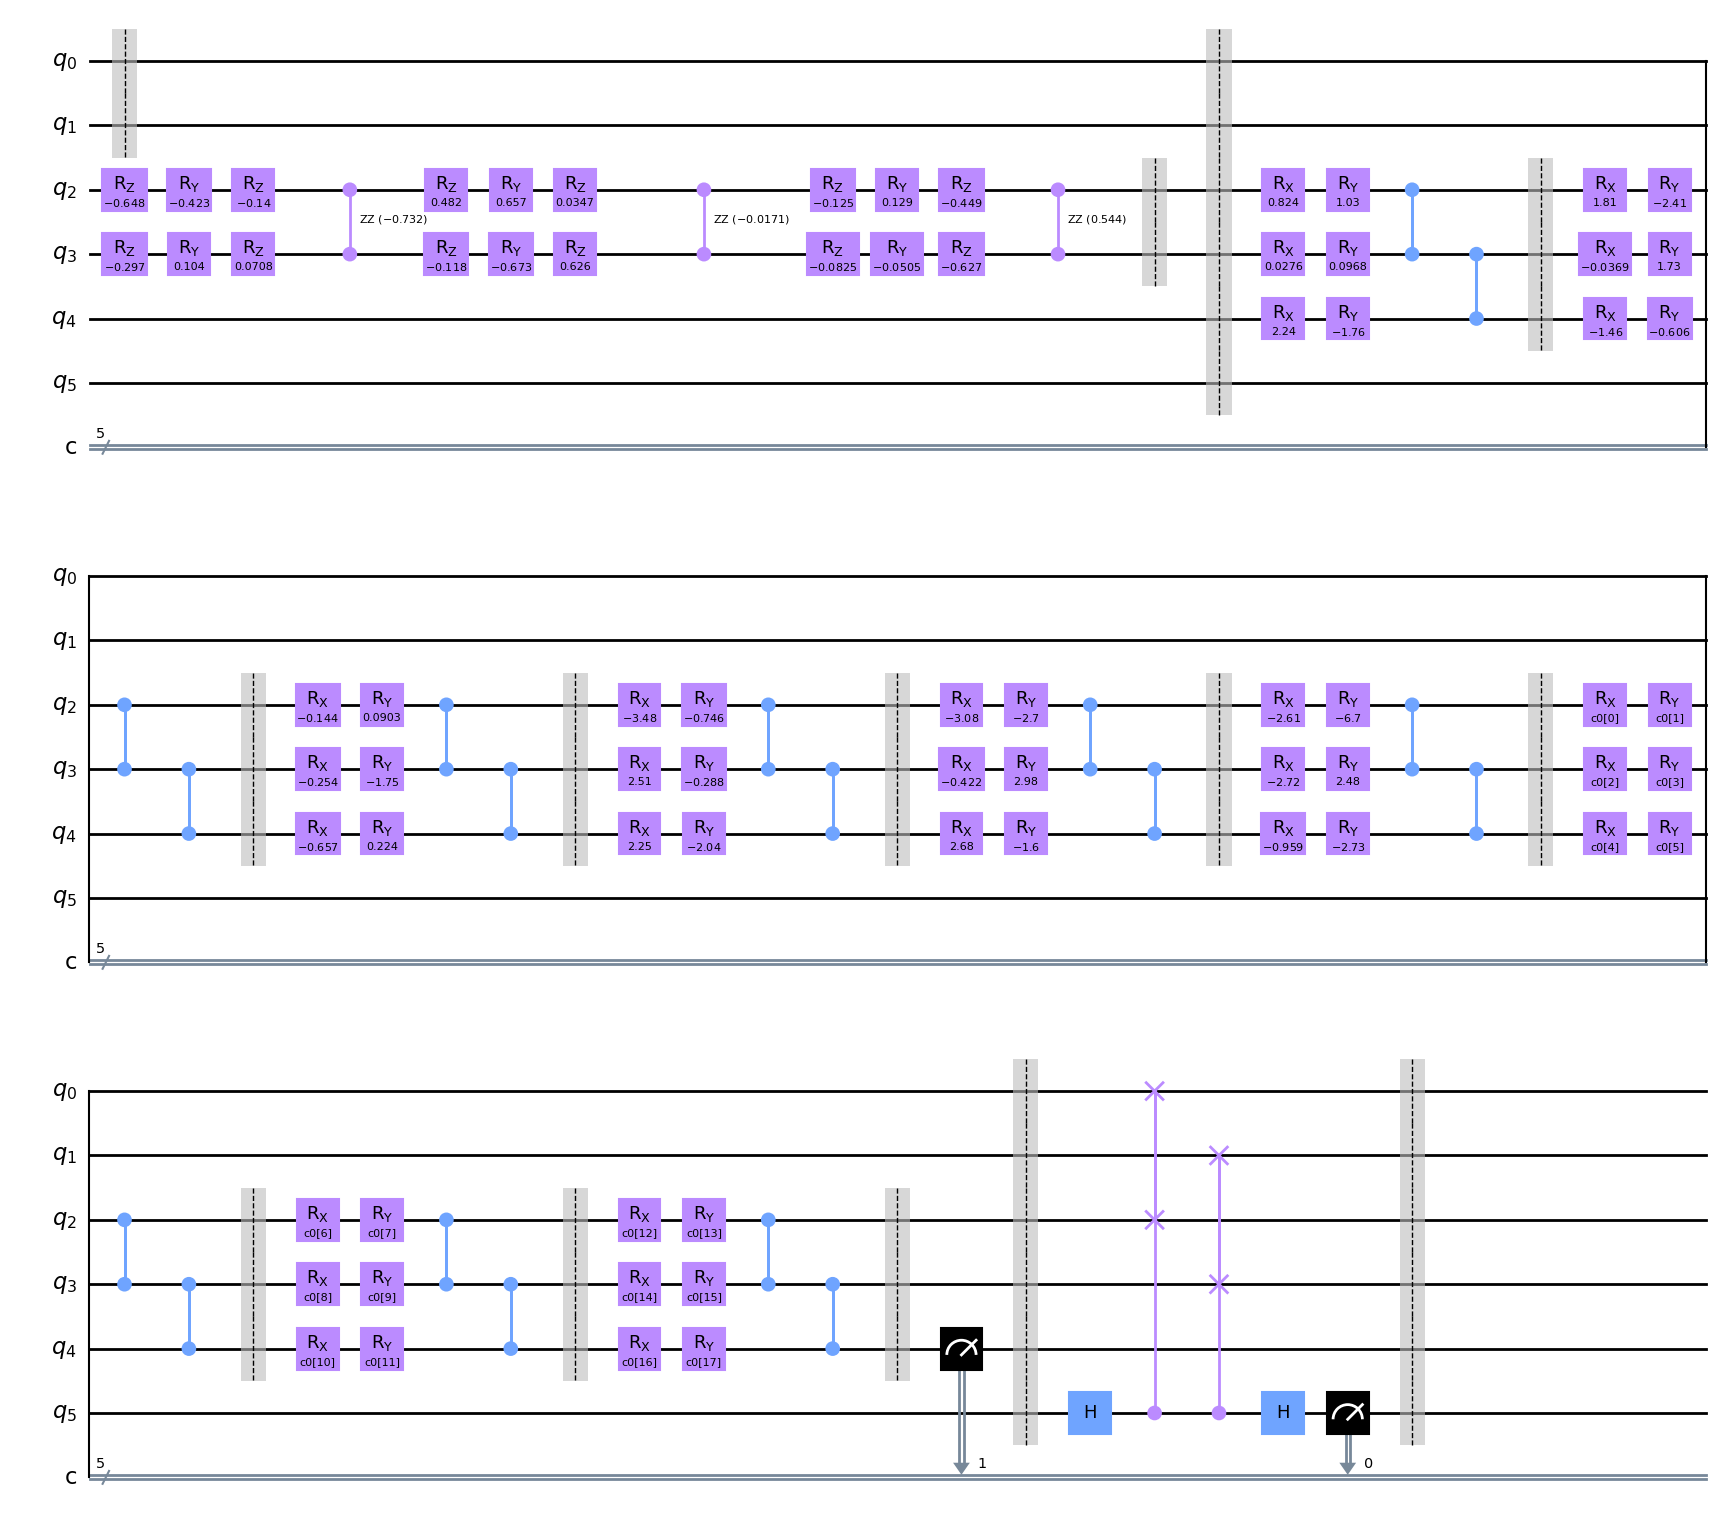

In [29]:
# 第三步去噪前，整体的diffusion,总步数为t=3步
time = 0
circlst3 = [QuantumCircuit(swapn,5) for num in range(mean)] #每个点独立的电路

for each in range(mean):

    randcp = [np.random.randint(0,repeat) for i in range(2)] #随机选取加噪去噪对
    
    for t in range(time): # reference diffusion 加噪
        for i in range(qbt):
            circlst3[each].rz(thetalst[t][randcp[0]][0+i*3],i)
            circlst3[each].ry(thetalst[t][randcp[0]][1+i*3],i)
            circlst3[each].rz(thetalst[t][randcp[0]][2+i*3],i)
        circlst3[each].rzz(zzthetalst[t][randcp[0]],0,1)
    circlst3[each].barrier(np.arange(2))

    for t in range(ttime): # total diffusion 整体加噪
        for i in range(qbt):
            circlst3[each].rz(thetalst[t][randcp[1]][0+i*3],2+i)
            circlst3[each].ry(thetalst[t][randcp[1]][1+i*3],2+i)
            circlst3[each].rz(thetalst[t][randcp[1]][2+i*3],2+i)
        circlst3[each].rzz(zzthetalst[t][randcp[1]],2,3)
    circlst3[each].barrier(np.arange(2,4))

    circlst3[each].barrier(np.arange(swapn))
    veclst.append(Statevector(circlst3[each])) #添加每个点的vector

# circlst3[0].draw('mpl')

#denoising process 加入第一二步去噪的结果
optimal_list = [optimal_parameters_1, optimal_parameters_2]
for each in range(mean):
    a = 0
    for alpha in ['a','b']:
        thetalstalpha = [ParameterVector(f'{alpha}{each}',18) for each in range(mean)]
        for n in range(layers):
            for i in range(totalq):
                circlst3[each].rx(thetalstalpha[each][0+2*i+n*2*totalq],i+2)
                circlst3[each].ry(thetalstalpha[each][1+2*i+n*2*totalq],i+2)
            for i in range(totalq):
                if i<totalq-1:
                    circlst3[each].cz(i+2,i+3)
            circlst3[each].barrier(range(2,2+totalq))
        circlst3[each] = circlst3[each].bind_parameters({thetalstalpha[each]: optimal_list[a]})
        a += 1


# circlst3[0].draw('mpl')

#denoising process 第三步去噪
layers = 3
thetalstc = [ParameterVector(f'c{each}',18) for each in range(mean)]

for each in range(mean):
    for n in range(layers):
        for i in range(totalq):
            circlst3[each].rx(thetalstc[each][0+2*i+n*2*totalq],i+2)
            circlst3[each].ry(thetalstc[each][1+2*i+n*2*totalq],i+2)
        for i in range(totalq):
            if i<totalq-1:
                circlst3[each].cz(i+2,i+3)
        circlst3[each].barrier(range(2,2+totalq))

    #swap test
    circlst3[each].measure(4,1) #测量辅助比特
    circlst3[each].barrier(range(swapn))
    circlst3[each].h(5)
    circlst3[each].cswap(5,0,2)
    circlst3[each].cswap(5,1,3)
    circlst3[each].h(5)
    circlst3[each].measure(5,0)
    circlst3[each].barrier(range(swapn))
    circlst3[each].draw('mpl')
circlst3[0].draw('mpl')

[ 1.79272879  1.55396355 -3.60041406  3.2077784  -2.02356048  0.41909192
  1.49990291  0.55043404 -2.79621118 -3.42469406 -0.09247885 -3.09134925
 -3.18578753  0.7709      0.36258585  0.70696624 -1.42343663 -0.50760299]
98.96


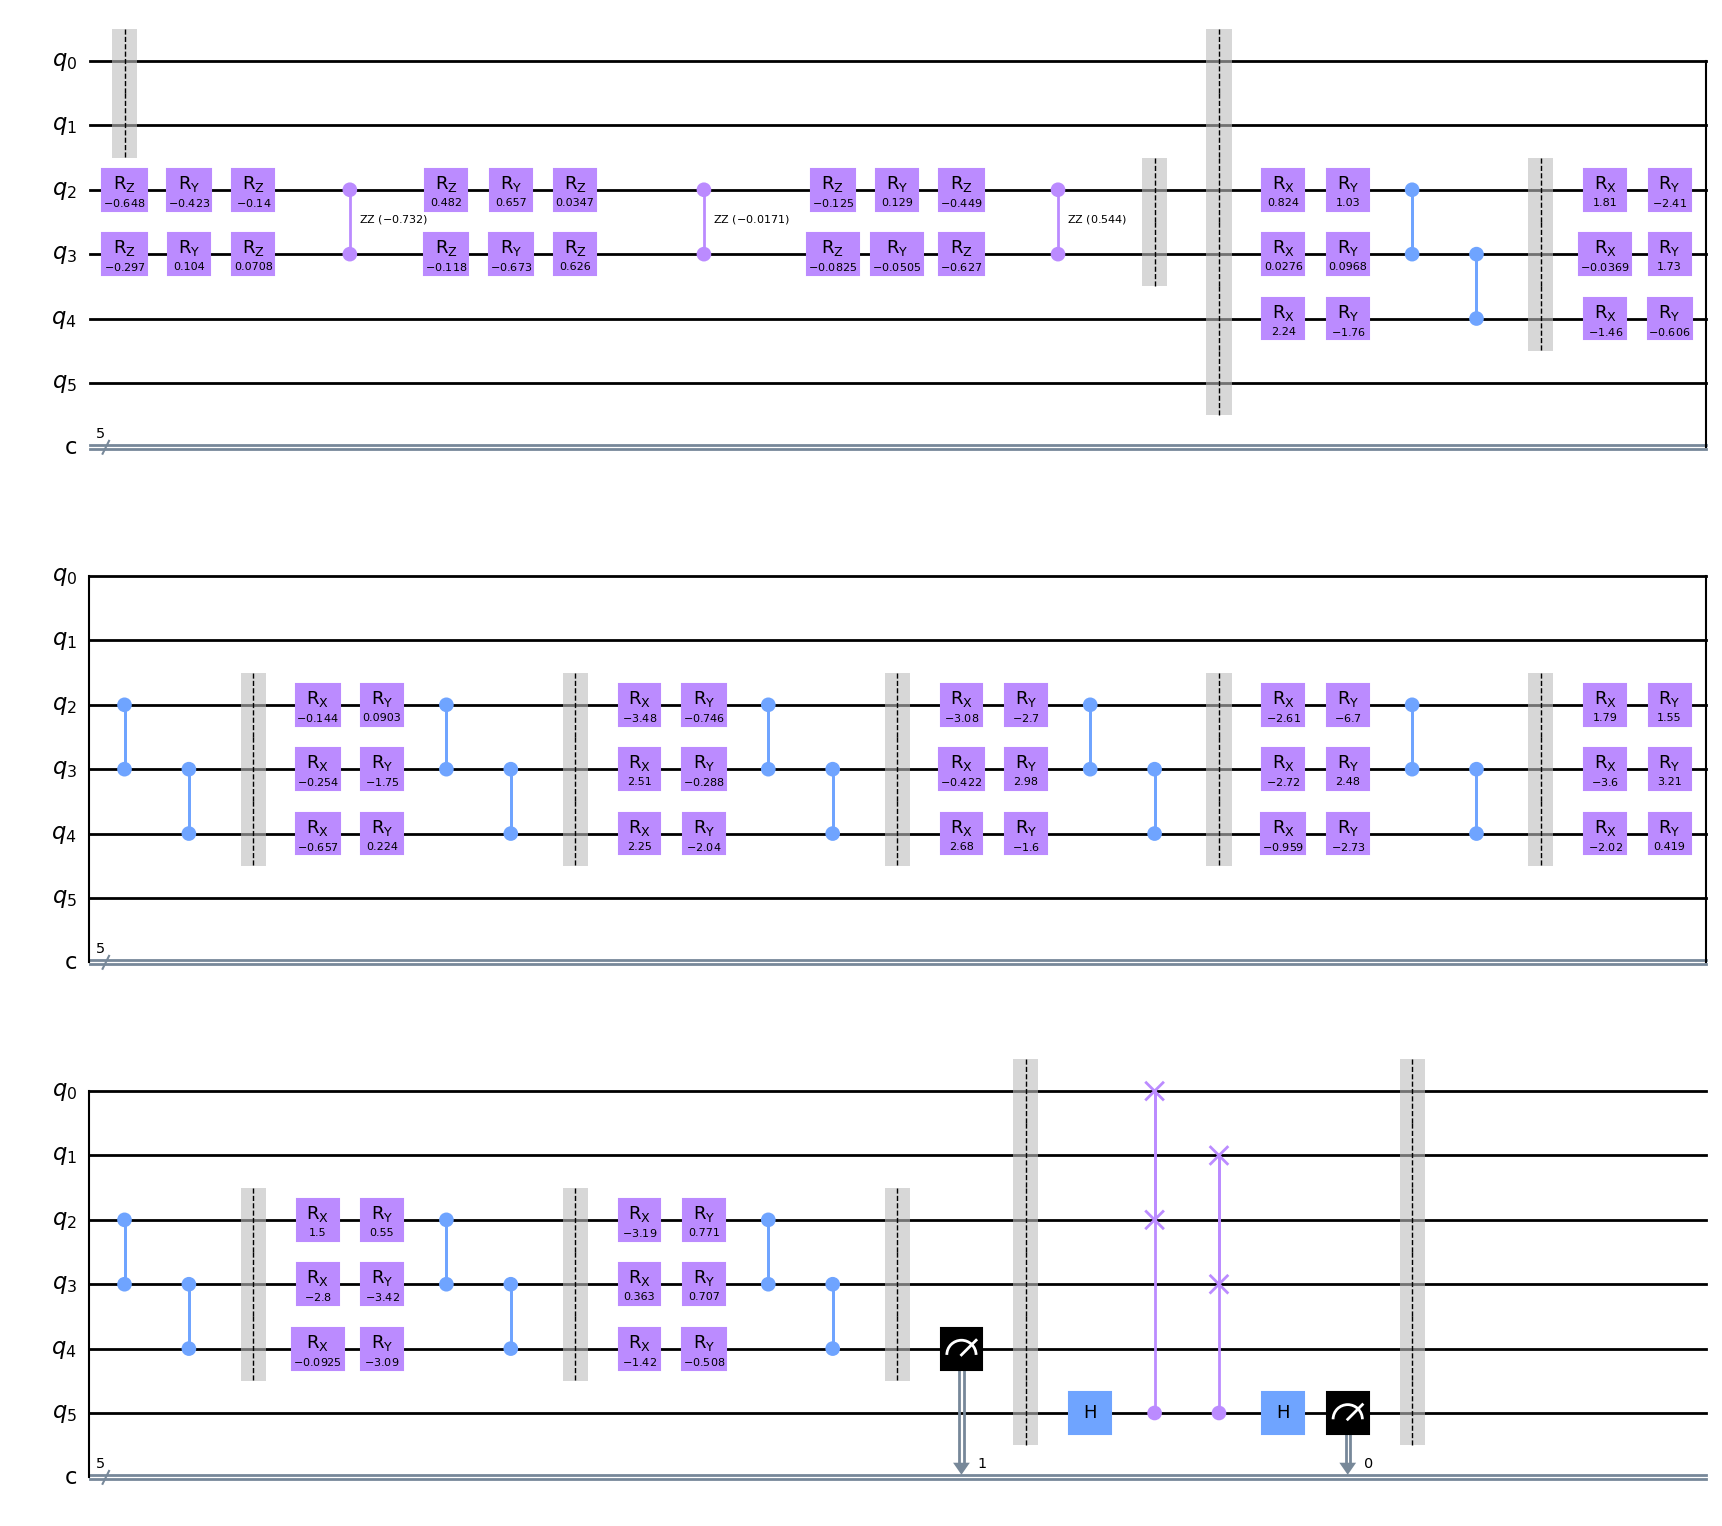

In [30]:
def cost_function_vqe_3(theta_range): #损失函数,这里xxxx0代表前向和后向重合,该值越大,去噪效果越好,因此需要最小xxxx1的频率
    count = 0
    for each in range(mean):
        circuits = circlst3[each].bind_parameters({thetalstc[each]: theta_range})
        job_sim = backend_sim.run(transpile(circuits, backend_sim), shots=1024)

        result_sim = job_sim.result()
        counts = result_sim.get_counts(circuits)

        for i in counts.keys():
            if i[-1]=='1':
                count += counts[i]
    return count/mean

### Optimizaion of denoising circuit parameters 优化参数

initial_theta = np.random.randn(18)
optimizer = SPSA() # 可选参数如 maxiter=150, blocking=True 增强优化效果

optimizer_result = optimizer.minimize(fun=cost_function_vqe_3, x0=initial_theta)
optimal_parameters_3 = optimizer_result.x

print(optimal_parameters_3)
print(cost_function_vqe_3(optimal_parameters_3))

for each in range(mean):
    circlst3[each] = circlst3[each].bind_parameters({thetalstc[each]: optimal_parameters_3})
circlst3[0].draw('mpl') #最终训练后的电路

In [31]:
# with open('opp3.txt','w') as f:
#     f.write(str(optimal_parameters_3))

现在我们构建训练后整体的加噪去噪电路

In [32]:
#测量电路x,y,z方向的函数
def msmt(cir): 
    xl=[]
    yl=[]
    zl=[]
    eps=10e-10
    for each in range(repeat):
        cir1 = cir[each].copy()
        cir2 = cir[each].copy()
        cir3 = cir[each].copy()

        cir1.measure([0,1,2],[0,1,2]) #z

        cir2.sdg(0)
        cir2.h(0)
        cir2.sdg(1)
        cir2.h(1)
        cir2.measure([0,1,2],[0,1,2])#y

        cir3.h(0)
        cir3.h(1)
        cir3.measure([0,1,2],[0,1,2])#x

        zyx = []
        for eachcir in [cir1, cir2, cir3]:
            job_sim = backend_sim.run(transpile(eachcir, backend_sim), shots=1024)
            result_sim = job_sim.result()
            counts1 = result_sim.get_counts(eachcir)
            count1 = 0
            count2 = 0
            for i in counts1.keys():
                    if i[-1]=='0':
                        count1 += counts1[i]
            z = count1 / 1024
            z = (z-0.5)*2
            zyx.append(z)

        # x *= np.sqrt((1-z**2)/(x**2+y**2+eps))
        # y *= np.sqrt((1-z**2)/(x**2+y**2+eps))
        z,y,x = zyx[:]
        zl.append(z)
        yl.append(y)
        xl.append(x)
    return xl, yl, zl

In [33]:
# optimal_lst = [optimal_parameters_1, optimal_parameters_2, optimal_parameters_3, optimal_parameters_4, optimal_parameters_5]
optimal_lst = [optimal_parameters_1, optimal_parameters_2, optimal_parameters_3]

[0.28515625, 0.880859375, 0.77734375, 0.900390625, 1.0, 0.927734375, 0.935546875, 0.5625, 0.673828125, 0.447265625, 0.921875, 0.97265625, 0.833984375, 0.8125, 0.783203125, 0.962890625, 0.548828125, 0.73046875, 0.890625, 0.630859375, 0.67578125, 0.89453125, 0.833984375, 0.88671875, 0.830078125, 0.986328125, 0.923828125, 0.97265625, 0.978515625, 0.947265625, 0.99609375, 0.65234375, 0.923828125, 0.873046875, 0.953125, 0.529296875, 0.79296875, 0.490234375, 0.58203125, 0.91015625, 0.560546875, 0.767578125, 0.6953125, 0.791015625, 0.244140625, 0.83203125, 0.8828125, 0.927734375, 0.673828125, 0.927734375, 0.66796875, 0.32421875, 0.5234375, 0.923828125, 0.7890625, 0.939453125, 0.68359375, 0.90625, 0.982421875, 0.890625, 0.130859375, 0.9140625, 0.94140625, 0.935546875, 0.755859375, 0.908203125, 0.41796875, 0.666015625, 0.3203125, 0.595703125, 0.970703125, 0.732421875, 0.74609375, 0.6875, 0.986328125, 0.91796875, 0.625, 0.931640625, 0.81640625, 0.916015625, 0.994140625, 0.990234375, 0.2734375, 0

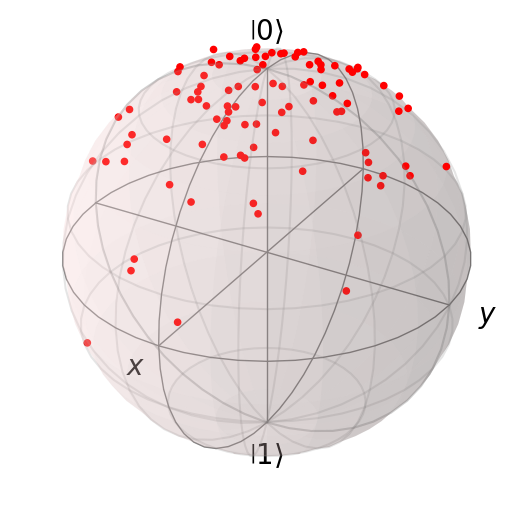

In [34]:
'''去噪前'''

cir = [QuantumCircuit(3,3) for each in range(repeat)]

for each in range(repeat):

    for t in range(ttime): # total diffusion 整体加噪
        for i in range(qbt):
            cir[each].rz(thetalst[t][each][0+i*3],i)
            cir[each].ry(thetalst[t][each][1+i*3],i)
            cir[each].rz(thetalst[t][each][2+i*3],i)
        cir[each].rzz(zzthetalst[t][each],0,1)
    cir[each].barrier(np.arange(2))

    cir[each].barrier(np.arange(6))
    
cir[0].draw('mpl')

## 对去噪前的量子比特在x,y,z方向进行测量，进而画出布洛赫球上的点

xl, yl, zl = msmt(cir)
print(zl)
print(sum(zl)/len(zl))
print(sum([y**2 for y in yl])/len(yl))

b = Bloch()

b.add_points([xl,yl,zl], "m")

b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']

# b.zlpos = [1.1, -1.2]
b.show()

[0.455078125, 0.703125, 0.572265625, 0.28515625, 0.8515625, 0.763671875, 0.88671875, 0.169921875, 0.564453125, 0.2734375, 0.681640625, 0.845703125, 0.44921875, 0.810546875, 0.369140625, 0.8828125, 0.349609375, 0.171875, 0.48046875, 0.029296875, 0.16015625, 0.640625, 0.654296875, 0.4296875, 0.83984375, 0.91796875, 0.529296875, 0.83203125, 0.8515625, 0.78125, 0.80078125, 0.115234375, 0.828125, 0.029296875, 0.091796875, 0.12890625, 0.380859375, 0.3359375, 0.662109375, 0.63671875, 0.376953125, 0.568359375, 0.154296875, 0.6015625, 0.072265625, 0.255859375, 0.69921875, 0.955078125, 0.755859375, 0.13671875, 0.52734375, 0.1328125, 0.3828125, 0.77734375, 0.44921875, 0.900390625, 0.59375, 0.8046875, 0.671875, 0.72265625, 0.3046875, 0.60546875, 0.947265625, 0.4609375, 0.583984375, 0.810546875, 0.333984375, 0.470703125, 0.28515625, 0.58203125, 0.71875, 0.79296875, 0.583984375, 0.69921875, 0.80859375, 0.751953125, 0.55859375, 0.87109375, 0.599609375, 0.880859375, -0.001953125, 0.8359375, 0.36132812

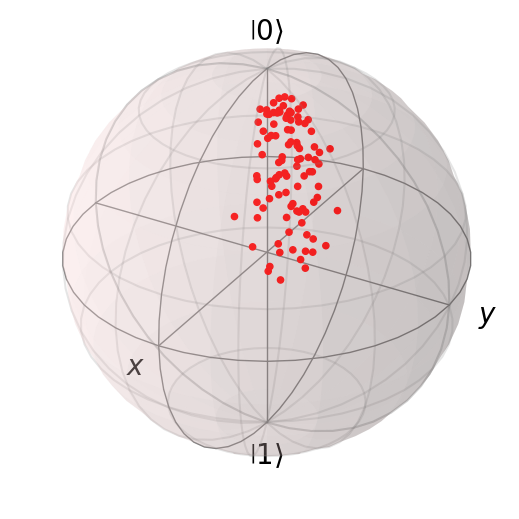

In [35]:
'''第一步去噪'''

cir = [QuantumCircuit(3,3) for each in range(repeat)]

for each in range(repeat):

    for t in range(ttime): # total diffusion 整体加噪
        for i in range(qbt):
            cir[each].rz(thetalst[t][each][0+i*3],i)
            cir[each].ry(thetalst[t][each][1+i*3],i)
            cir[each].rz(thetalst[t][each][2+i*3],i)
        cir[each].rzz(zzthetalst[t][each],0,1)
    cir[each].barrier(np.arange(2))

    cir[each].barrier(np.arange(6))
    
# cir[0].draw('mpl')

#denoising process 加入第一步去噪的结果
layers = 3
pn=18 #每一步参数数目

for each in range(repeat):
    thetalsta = [ParameterVector(f'a{each}',18) for each in range(repeat)]

    for n in range(layers):
        for i in range(totalq):
            cir[each].rx(thetalsta[each][0+2*i+n*2*totalq],i)
            cir[each].ry(thetalsta[each][1+2*i+n*2*totalq],i)
        for i in range(totalq):
            if i<totalq-1:
                cir[each].cz(i,i+1)
        cir[each].barrier(range(totalq))

    cir[each] = cir[each].bind_parameters({thetalsta[each]: optimal_parameters_1})
cir[0].draw('mpl')

## 对去噪后的量子比特在x,y,z方向进行测量，进而画出布洛赫球上的点
xl, yl, zl = msmt(cir)

print(zl)
print(sum(zl)/len(zl))
print(sum([y**2 for y in yl])/len(yl))

b = Bloch()

b.add_points([xl,yl,zl], "m")

b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']

# b.zlpos = [1.1, -1.2]
b.show()

[0.33984375, 0.78515625, 0.5546875, 0.5390625, 0.9453125, 0.5859375, 0.939453125, 0.271484375, 0.66796875, 0.466796875, 0.873046875, 0.791015625, 0.41796875, 0.6953125, 0.658203125, 0.923828125, 0.5, 0.3125, 0.3125, 0.447265625, 0.30859375, 0.810546875, 0.7109375, 0.5390625, 0.72265625, 0.876953125, 0.458984375, 0.802734375, 0.818359375, 0.728515625, 0.908203125, 0.109375, 0.625, -0.1953125, 0.25, 0.359375, 0.630859375, 0.140625, 0.60546875, 0.6015625, 0.505859375, 0.607421875, 0.298828125, 0.701171875, 0.21484375, 0.5703125, 0.669921875, 0.869140625, 0.619140625, 0.525390625, 0.662109375, 0.384765625, 0.484375, 0.814453125, 0.501953125, 0.94921875, 0.62109375, 0.83984375, 0.896484375, 0.869140625, 0.1953125, 0.7734375, 0.908203125, 0.255859375, 0.720703125, 0.908203125, 0.486328125, 0.349609375, 0.232421875, 0.572265625, 0.611328125, 0.654296875, 0.716796875, 0.697265625, 0.919921875, 0.76953125, 0.615234375, 0.8828125, 0.4921875, 0.916015625, 0.38671875, 0.8515625, 0.283203125, 0.376

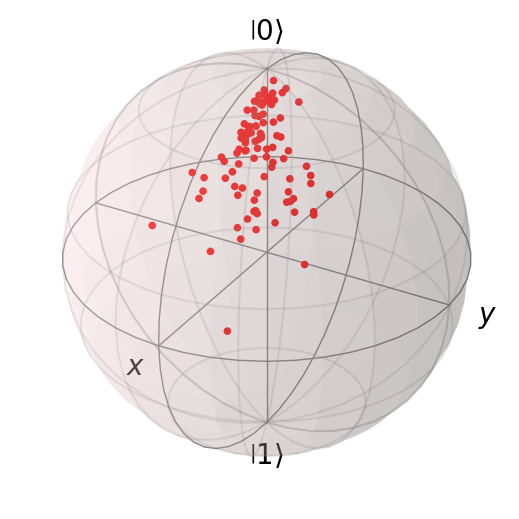

In [36]:
'''第二步去噪'''

cir = [QuantumCircuit(3,3) for each in range(repeat)]

for each in range(repeat):

    for t in range(ttime): # total diffusion 整体加噪
        for i in range(qbt):
            cir[each].rz(thetalst[t][each][0+i*3],i)
            cir[each].ry(thetalst[t][each][1+i*3],i)
            cir[each].rz(thetalst[t][each][2+i*3],i)
        cir[each].rzz(zzthetalst[t][each],0,1)
    cir[each].barrier(np.arange(2))

    cir[each].barrier(np.arange(6))
    
# cir[0].draw('mpl')

#denoising process 加入第一二步去噪的结果
layers = 3
pn=18 #每一步参数数目

for each in range(repeat):
    a = 0
    for alpha in ['a','b']:
        thetalstalpha = [ParameterVector(f'{alpha}{each}',18) for each in range(repeat)]
        for n in range(layers):
            for i in range(totalq):
                cir[each].rx(thetalstalpha[each][0+2*i+n*2*totalq],i)
                cir[each].ry(thetalstalpha[each][1+2*i+n*2*totalq],i)
            for i in range(totalq):
                if i<totalq-1:
                    cir[each].cz(i,i+1)
            cir[each].barrier(range(totalq))
        cir[each] = cir[each].bind_parameters({thetalstalpha[each]: optimal_lst[a]})
        a += 1

# cir[0].draw('mpl')
## 对去噪后的量子比特在x,y,z方向进行测量，进而画出布洛赫球上的点
xl, yl, zl = msmt(cir)
print(zl)
print(sum(zl)/len(zl))
print(sum([y**2 for y in yl])/len(yl))

b = Bloch()

b.add_points([xl,yl,zl], "m")

b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']

# b.zlpos = [1.1, -1.2]
b.show()

[0.69140625, 0.9609375, 0.744140625, 0.876953125, 0.982421875, 0.86328125, 0.896484375, 0.759765625, 0.6953125, 0.619140625, 0.9140625, 0.93359375, 0.8359375, 0.873046875, 0.76171875, 0.93359375, 0.77734375, 0.482421875, 0.703125, 0.5390625, 0.521484375, 0.78125, 0.923828125, 0.724609375, 0.84375, 0.9765625, 0.69140625, 0.890625, 0.943359375, 0.822265625, 0.953125, 0.46484375, 0.859375, 0.279296875, 0.650390625, 0.615234375, 0.6875, 0.482421875, 0.896484375, 0.861328125, 0.6328125, 0.876953125, 0.568359375, 0.849609375, 0.66796875, 0.72265625, 0.890625, 0.939453125, 0.830078125, 0.6171875, 0.75, 0.810546875, 0.654296875, 0.884765625, 0.806640625, 0.95703125, 0.802734375, 0.921875, 0.880859375, 0.86328125, 0.685546875, 0.849609375, 0.958984375, 0.63671875, 0.779296875, 0.962890625, 0.625, 0.54296875, 0.544921875, 0.71875, 0.828125, 0.865234375, 0.81640625, 0.919921875, 0.9296875, 0.904296875, 0.826171875, 0.955078125, 0.884765625, 0.966796875, 0.654296875, 0.890625, 0.462890625, 0.64843

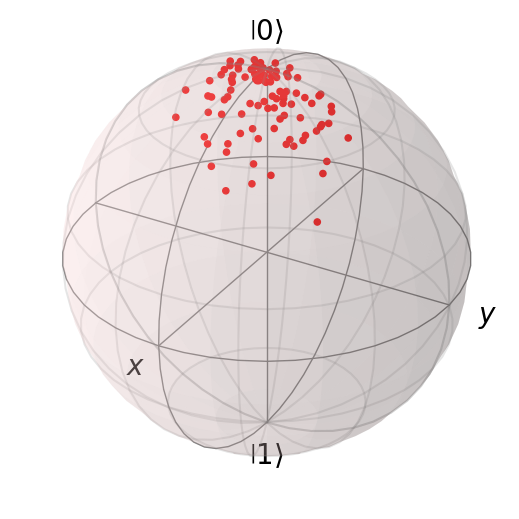

In [37]:
'''第三步去噪'''

cir = [QuantumCircuit(3,3) for each in range(repeat)]

for each in range(repeat):

    for t in range(ttime): # total diffusion 整体加噪
        for i in range(qbt):
            cir[each].rz(thetalst[t][each][0+i*3],i)
            cir[each].ry(thetalst[t][each][1+i*3],i)
            cir[each].rz(thetalst[t][each][2+i*3],i)
        cir[each].rzz(zzthetalst[t][each],0,1)
    cir[each].barrier(np.arange(2))

    cir[each].barrier(np.arange(6))
    
# cir[0].draw('mpl')

#denoising process 加入第一二三步去噪的结果
layers = 3
pn=18 #每一步参数数目

for each in range(repeat):
    a = 0
    for alpha in ['a','b','c']:
        thetalstalpha = [ParameterVector(f'{alpha}{each}',18) for each in range(repeat)]
        for n in range(layers):
            for i in range(totalq):
                cir[each].rx(thetalstalpha[each][0+2*i+n*2*totalq],i)
                cir[each].ry(thetalstalpha[each][1+2*i+n*2*totalq],i)
            for i in range(totalq):
                if i<totalq-1:
                    cir[each].cz(i,i+1)
            cir[each].barrier(range(totalq))
        cir[each] = cir[each].bind_parameters({thetalstalpha[each]: optimal_lst[a]})
        a += 1

cir[1].draw('mpl')

## 对去噪后的量子比特在x,y,z方向进行测量，进而画出布洛赫球上的点
xl, yl, zl = msmt(cir)
print(zl)
print(sum(zl)/len(zl))
print(sum([y**2 for y in yl])/len(yl))

b = Bloch()

b.add_points([xl,yl,zl], "m")

b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']

# b.zlpos = [1.1, -1.2]
b.show()

测试完全混态的去噪效果

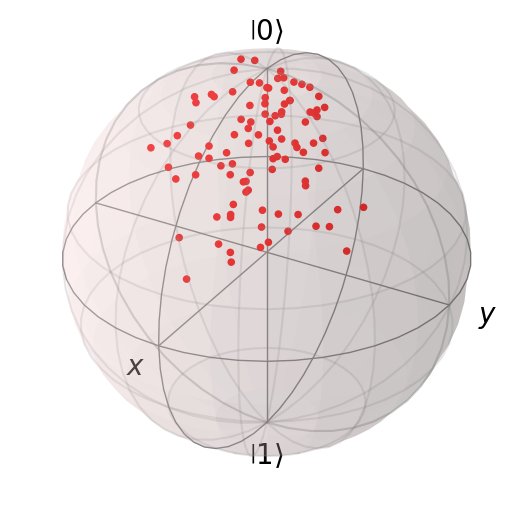

In [38]:
cir = [QuantumCircuit(3,3) for each in range(repeat)]
for each in range(repeat):
    for t in range(10): # total diffusion 整体加噪
        for i in range(qbt):
            random_thetalst = (np.random.rand(3*qbt)-0.5)*theta_scale
            cir[each].rz(random_thetalst[0+3*i],i)
            cir[each].ry(random_thetalst[1+3*i],i)
            cir[each].rz(random_thetalst[2+3*i],i)
        cir[each].rzz((np.random.rand()-0.5)*theta_scale,0,1)
    cir[each].barrier(np.arange(2))
    cir[each].barrier(np.arange(6))
    
# cir[0].draw('mpl')

#denoising process 加入第一二三四五步去噪的结果
layers = 3
pn=18 #每一步参数数目

for each in range(repeat):
    a = 0
    for alpha in ['a','b','c']: 
        thetalstalpha = [ParameterVector(f'{alpha}{each}',18) for each in range(repeat)]
        for n in range(layers):
            for i in range(totalq):
                cir[each].rx(thetalstalpha[each][0+2*i+n*2*totalq],i)
                cir[each].ry(thetalstalpha[each][1+2*i+n*2*totalq],i)
            for i in range(totalq):
                if i<totalq-1:
                    cir[each].cz(i,i+1)
            cir[each].barrier(range(totalq))
        cir[each] = cir[each].bind_parameters({thetalstalpha[each]: optimal_lst[a]})
        a += 1

## 对去噪后的量子比特在x,y,z方向进行测量，进而画出布洛赫球上的点
xl, yl, zl = msmt(cir)

b = Bloch()

b.add_points([xl,yl,zl], "m")

b.point_marker = ["o"]
b.point_size = [20]
b.point_color = ['r']

# b.zlpos = [1.1, -1.2]
b.show()